In [25]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

base_path = "run_logs/" # TODO: replace
series_name = "sim/test/return"
file_name = "arr.csv" # TODO: replace

In [52]:
def parse_tf_events_file(folder_name, series_name=series_name):
    if not folder_name[-1] == "/":
        folder_name = folder_name + "/"
    full_folder_name = base_path + folder_name
    all_files = os.listdir(full_folder_name)
    file_name = [f for f in all_files if "events.out.tfevents" in f][0]
    file_name = full_folder_name + file_name
    eval_returns = []
    for e in tf.train.summary_iterator(file_name):
        for v in e.summary.value:
            if v.tag == series_name:
                eval_returns.append(v.simple_value)

    return pd.DataFrame(data=eval_returns, columns="Returns")

def parse_csv_file(file_name):
    return pd.read_csv(file_name).values[:,2]

def plot(file_names, legend, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
         load_from_tb=False, base_dir=None, file_name=file_name, avg_every=None):
    for run_name in file_names:
        if base_dir is not None:
            full_file_name = os.path.join(base_dir, run_name, file_name)
        if load_from_tb:
            csv = parse_tf_events_file(full_file_name)
        else:
            csv = parse_csv_file(full_file_name)
        if avg_every:
            csv = csv.groupby(np.arange(len(csv))//avg_every).mean()
        
        x = np.array(range(len(csv))) * scale
        plt.plot(x, csv)
    if legend:
        plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.show()

    
def plot_avg(file_names_list, legend, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
             load_from_tb=False, base_dir=None, file_name=file_name, avg_every=None):
    for file_names in file_names_list:
        runs = []
        for run_name in file_names:
            if base_dir is not None:
                full_file_name = os.path.join(base_dir, run_name, file_name)
            if load_from_tb:
                csv = parse_tf_events_file(full_file_name)
            else:
                csv = parse_csv_file(full_file_name)
            if avg_every:
                csv = pd.DataFrame(csv).groupby(np.arange(len(csv))//avg_every).mean().values[:, 0]
            runs.append(csv)
        mean_arr = np.mean(np.stack(runs), axis=0)
        std_arr = np.std(np.stack(runs), axis=0)
        x = np.array(range(len(mean_arr))) * scale
        plt.plot(x, mean_arr)
        plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)

    if legend:
        plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.show()


In [6]:
ratio_dict = {
    "1:1": 0,
    "10:1": 1,
    "100:1": 2,
    "No real": 3,
}
outer_loop_dict = {
    "No outer loop": 1 ,
    "Outer loop 1": 2,
    "Outer loop 2": 3,
}
seed_dict = {
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
}
condition_dict = {
    "correct mass, small range": 0,
    "correct mass, large range": 1,
    "small mass, small range": 2,
    "small mass, large non-covering range": 3,
    "small mass, large covering range range": 4,
    "large mass, small range": 5,
    "large mass, large non-covering range range": 6,
    "large mass, large covering range range": 7,
}
def filter_by_ratio(files, condition):
    value = str(ratio_dict[condition])
    return list(filter(lambda x: x[2] == value, files))

def filter_by_outer_loop(files, condition):
    value = str(outer_loop_dict[condition])
    return list(filter(lambda x: x[1] == value, files))

def filter_by_seed(files, condition):
    value = str(seed_dict[condition])
    return list(filter(lambda x: x[5] == value, files))

def filter_by_condition(files, condition):
    value = str(condition_dict[condition])
    return list(filter(lambda x: x[3] == value, files))


In [ ]:
x = filter_by_outer_loop(["01hello"], "No outer loop")
print(x)
print(list(x))

# No Outer Loop

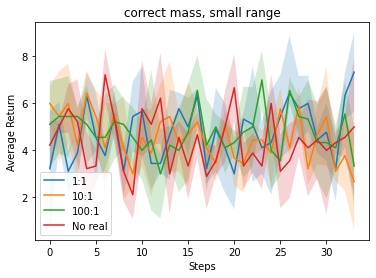

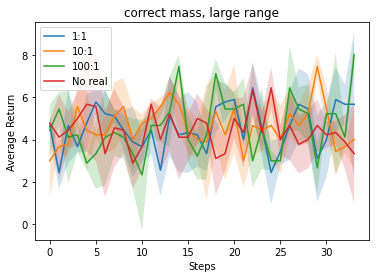

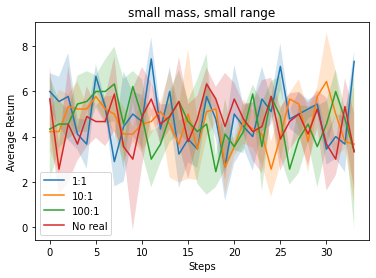

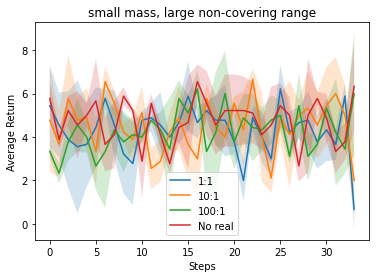

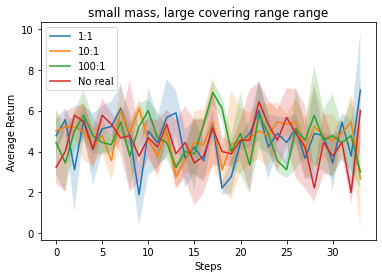

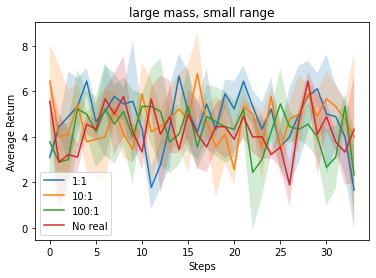

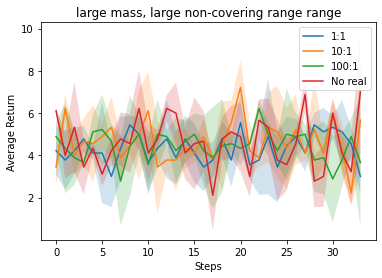

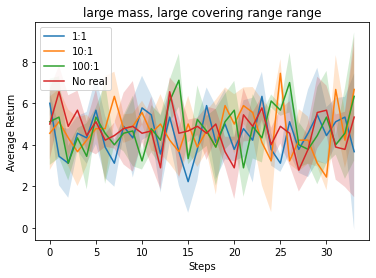

In [54]:
load_from_tb = False # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
files = filter_by_outer_loop(files, "No outer loop")
# Loop through different conditions:
for condition in condition_dict.keys():
    condition_files = filter_by_condition(files, condition)
    # Generate a single plot for each condition
    plot_files = []
    labels = []
    for ratio in ratio_dict.keys():
        ratio_files = filter_by_ratio(condition_files, ratio)
        if len(ratio_files) > 0:
            plot_files.append(ratio_files)
            labels.append(ratio)
        
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    plot_avg(plot_files, labels, "Steps", "Average Return", condition, 
             save_name=f"noouter_{condition}.png", base_dir=base_path,
             avg_every=3)



In [37]:
# Generating fake data so we can test the function

# # os.mkdir(base_path)
# for outer_loop in outer_loop_dict.values():
#     for condition in condition_dict.values():
#         for ratio in ratio_dict.values():
#             for seed in range(3):
#                 id_str = str(0) + str(outer_loop) + str(ratio) + str(condition) + "_" + str(seed)
#                 path = os.path.join(base_path, id_str)
# #                 os.mkdir(path)
#                 arr = np.random.randint(0, 10, size=(100, 3))
#                 array = pd.DataFrame(data=arr, columns=["Temp1", "Temp2", "Temp3"]).to_csv()
#                 with open(path + "/arr.csv", "w") as f:
#                     f.write(array)

# Outer Loop

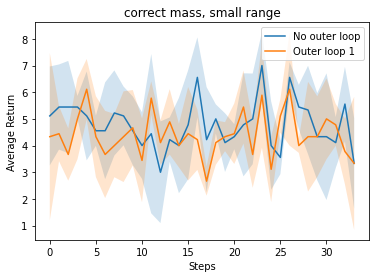

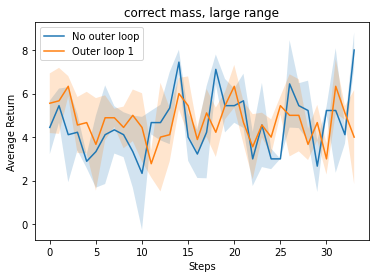

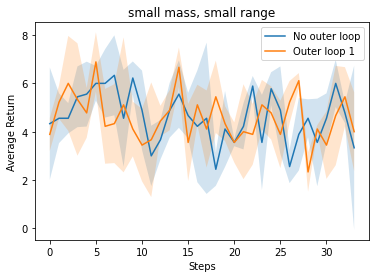

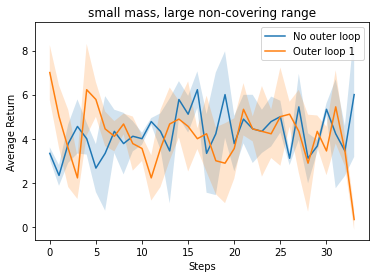

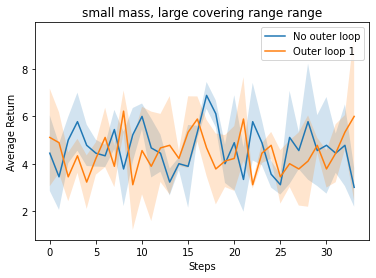

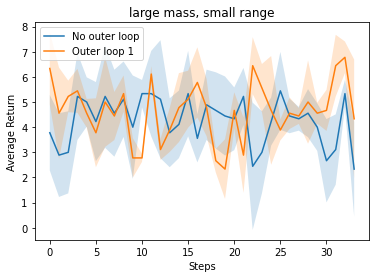

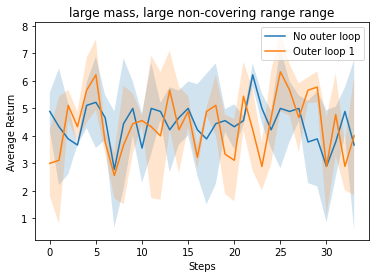

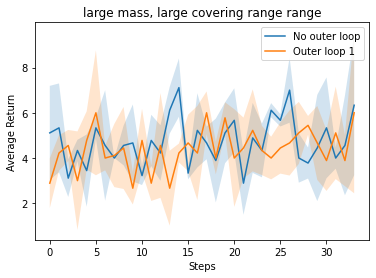

In [55]:
load_from_tb = False # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
# Loop through different conditions:
for condition in condition_dict.keys():
    condition_files = filter_by_condition(files, condition)
    # Generate a single plot for each condition
    plot_files = []
    labels = []
    ratio = "100:1" # or we could loop through multiple values for this
    ratio_files = filter_by_ratio(condition_files, ratio)
    no_outer_files = filter_by_outer_loop(ratio_files, "No outer loop")
    outer_files = filter_by_outer_loop(ratio_files, "Outer loop 1")
    plot_files = [no_outer_files, outer_files]
    labels = ["No outer loop", "Outer loop 1"]
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    plot_avg(plot_files, labels, "Steps", "Average Return", condition, 
             save_name=f"outer_{condition}.png", base_dir=base_path,
             avg_every=3)

